In [40]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [25]:
data=pd.read_csv('LoanApprovalPrediction.csv')

In [26]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [27]:
data.shape

(614, 13)

In [28]:
data.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [29]:
data=data.drop(columns='Loan_ID',axis=1)

In [37]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

In [38]:
print(X.shape)
print(y.shape)

(614, 11)
(614,)


In [39]:
cat_col=[feature for feature in X.columns if X[feature].dtype=='O']
print(cat_col)
num_col=[feature for feature in X.columns if X[feature].dtype!='O']
print(num_col)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [31]:
print(data['Gender'].value_counts())
print('='*12)
print(data['Married'].value_counts())
print('='*12)
print(data['Dependents'].value_counts())
print('='*12)
print(data['Education'].value_counts())
print('='*12)
print(data['Self_Employed'].value_counts())
print('='*12)
print(data['Property_Area'].value_counts())
print('='*12)
print(data['Loan_Status'].value_counts())
print('='*12)

Male      489
Female    112
Name: Gender, dtype: int64
Yes    398
No     213
Name: Married, dtype: int64
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
No     500
Yes     82
Name: Self_Employed, dtype: int64
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Y    422
N    192
Name: Loan_Status, dtype: int64


<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

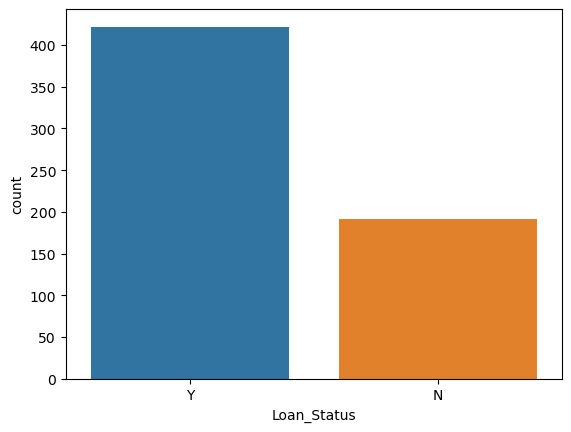

In [32]:
sns.countplot(data['Loan_Status'])

In [43]:
num_pipeline=Pipeline(steps=(['imputer',SimpleImputer(strategy='median')],
                            ['scaler',StandardScaler()]))
cat_pipeline=Pipeline(steps=(['imputer',SimpleImputer(strategy='most_frequent')],
                            ['encoder',OneHotEncoder()]))
preprocessor=ColumnTransformer([('numerical_pipeline',num_pipeline,num_col),
                              ('categorical_pipeline',cat_pipeline,cat_col)])

In [44]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=35)

In [45]:
print(X_train.shape)
print(X_test.shape)

(429, 11)
(185, 11)


In [46]:
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)

In [50]:
models={'LogisticRegression': LogisticRegression(),
       'RandomForest':RandomForestClassifier(),
       'GradientBoosting':GradientBoostingClassifier()}
params={'LogisticRegression':{'max_iter':[100],'penalty':['l2']},
       'RandomForest':{'n_estimators': [100,300,500],'max_depth':[15],'min_samples_split':[5],'random_state':[1]},
       'GradientBoosting':{'n_estimators': [100,300,500],'max_depth':[15],'min_samples_split' :[5],'random_state':[1]}}

In [53]:
def evaluate_models(X_train,X_test,y_train,y_test,models,params):
    report={}
    for i in range(len(list(models))):
        model=list(models.values())[i]
        param=params[list(models.keys())[i]]
        
        gs=GridSearchCV(model,param,cv=3)
        gs.fit(X_train,y_train)
        
        model.set_params(**gs.best_params_)
        model.fit(X_train,y_train)
        
        y_test_pred=model.predict(X_test)
        acc_score=(accuracy_score(y_test,y_test_pred))*100
        
        print(f'{list(models.keys())[i]} :')
        print(classification_report(y_test,y_test_pred))
        
        report[list(models.keys())[i]]=acc_score
        
        best_score=max(list(report.values()))
        best_model=list(filter(lambda x:report[x]==best_score,report))[0]
    print(f'The Best score of models:{best_model} : {best_score}')
    return report

In [54]:
evaluate_models(X_train,X_test,y_train,y_test,models,params)

LogisticRegression :
              precision    recall  f1-score   support

           N       1.00      0.40      0.57        48
           Y       0.83      1.00      0.90       137

    accuracy                           0.84       185
   macro avg       0.91      0.70      0.74       185
weighted avg       0.87      0.84      0.82       185

RandomForest :
              precision    recall  f1-score   support

           N       0.72      0.44      0.55        48
           Y       0.83      0.94      0.88       137

    accuracy                           0.81       185
   macro avg       0.78      0.69      0.71       185
weighted avg       0.80      0.81      0.79       185

GradientBoosting :
              precision    recall  f1-score   support

           N       0.51      0.44      0.47        48
           Y       0.81      0.85      0.83       137

    accuracy                           0.75       185
   macro avg       0.66      0.65      0.65       185
weighted avg       

{'LogisticRegression': 84.32432432432432,
 'RandomForest': 81.08108108108108,
 'GradientBoosting': 74.5945945945946}